## Features of `easyparser`

In this notebook, we will walk through the basic features that easyparser provides. Our objective is to showcase (1) how to parse, chunk a file; (2) the unique features of `Chunk` - the graph-based representation of a document - and what it provides.

### Parse from files and folders into `Chunk`

`easyparser` provides a high-level `parse` function, that is capable of parsing files and folders. In this notebook, we will demonstrate its capability on the `assets` folder, located on the same level with this notebook. First, we will show how to parse a file.

In [1]:
from easyparser import parse

chunk = parse("assets/sample.docx")

The file is parsed into Chunk. A Chunk is a graph that represents the document based on its layout structure. We can run `chunk.print_graph()` to view the structural content of the above file. Detailed information about this `Chunk` representation will be discussed later.

```python
>> chunk.print_graph()

# truncated output
Chunk(ctype=root, content=File assets/sample.docx)
    Chunk(ctype=para, content=(abridged from Sam Gross’s doc: https://docs.googl... (1 more words))
    Chunk(ctype=para, content=The goal of this project is to remove the global i... (31 more words))
    Chunk(ctype=list, mimetype=text/plain)
        Chunk(ctype=list, content=1. That it is feasible to remove the GIL from Python.)
        Chunk(ctype=list, content=2. That the tradeoffs are manageable and the effor... (7 more words))
        Chunk(ctype=list, content=3. That the main technical ideas of this project (... (16 more words))
    Chunk(ctype=header, content=Why remove the GIL?)
        Chunk(ctype=para, content=The GIL is a major obstacle to concurrency. For sc... (52 more words))
    Chunk(ctype=header, content=Design)
        Chunk(ctype=header, content=Reference counting)
            Chunk(ctype=para, content=CPython’s reference counting system is not thread-... (48 more words))
            ...
```

You can print the loaded text with `chunk.render()`. 

In [2]:
text = chunk.render()
print("(Printing the fourth of the content)\n")
print(text[:len(text) // 4])
print("======")

(Printing the fourth of the content)

(abridged from Sam Gross’s doc: https://docs.google.com/document/d/18CXhDb1ygxg-YXNBJNzfzZsDFosB5e6BfnXLlejd9l0/edit?tab=t.0#heading=h.kcngwrty1lv)

The goal of this project is to remove the global interpreter lock (GIL) from CPython to enable multiple threads to execute Python code in parallel. The purpose of this document and associated code is to convince you of a few things:
1. That it is feasible to remove the GIL from Python.
2. That the tradeoffs are manageable and the effort to remove the GIL is worthwhile.
3. That the main technical ideas of this project (reference counting, allocator changes, and thread-safety scheme) should serve as a basis of such an effort.

Why remove the GIL?

The GIL is a major obstacle to concurrency. For scientific computing tasks, this lack of concurrency is often a bigger issue than speed of executing Python code, since most of the processor cycles are spent in optimized CPU or GPU kernels. The GIL introduces a 

`easyparser` determines the parser based on the mimetype. You can see the current supported mimetypes and its parsers here (as of May 2025).

In [3]:
from easyparser.controller import get_controller
ctrl = get_controller()
for _mime, _parsers in ctrl._parsers.items():
    print(f"- {_mime}: {_parsers}")
print("=====")

- text/plain: [<class 'easyparser.parser.text.TextParser'>]
- text/html: [<class 'easyparser.parser.html.PandocHtmlParser'>, <class 'easyparser.parser.pandoc_engine.PandocEngine'>, <class 'easyparser.parser.text.TextParser'>]
- text/markdown: [<class 'easyparser.parser.md.Markdown'>, <class 'easyparser.parser.text.TextParser'>]
- text/x-rst: [<class 'easyparser.parser.pandoc_engine.PandocEngine'>, <class 'easyparser.parser.text.TextParser'>]
- text/org: [<class 'easyparser.parser.pandoc_engine.PandocEngine'>, <class 'easyparser.parser.text.TextParser'>]
- text/x-tex: [<class 'easyparser.parser.pandoc_engine.PandocEngine'>, <class 'easyparser.parser.text.TextParser'>]
- image/jpeg: [<class 'easyparser.parser.image.RapidOCRImageText'>]
- image/png: [<class 'easyparser.parser.image.RapidOCRImageText'>]
- application/pdf: [<class 'easyparser.parser.pdf.FastPDF'>]
- application/vnd.openxmlformats-officedocument.wordprocessingml.document: [<class 'easyparser.parser.pandoc_engine.PandocEngine

Some mimetypes have more than 1 parsers, to ensure that when one parser fails, we can fallback to a the next parser to parse that file.

Using the high level `parse` interface, users can supply their own customized parsers to the `extras` and/or `callbacks` parameters as follow. Where `extras` is a dictionary that maps from the mimetype string to the expected parsers. The `callbacks` are list of functions that map from the (filepath and mimetype) to Parser.

```python
chunk = parse(
    <path>,
    extras={"image/tif": [TiffParser]},
    callbacks=[lambda path, mime: OtherParser],
)
```

easyparser also supports parsing a directory. The output Chunk list will also reflect directory hierarchy. Here, after parsing, we will print the chunk hierarchy but limiting to chunks that correspond to file, folder and headers.

In [4]:
folder_chunks = parse("assets")

# limit printing only the root (corresponds to files and folders), and header in each file
for chunk in folder_chunks:
    chunk.print_graph(ctype=["root", "header"])

[WARNING][easyparser] 2025-05-26 17:43:09 controller.py:131: Unsupported mimetype: inode/directory. Please register in **extras, or make a Github issue
2025-05-26 17:43:10,052 - DownloadModel - INFO: /Users/taprosoft/miniconda3/lib/python3.12/site-packages/rapid_layout/models/yolov8n_layout_general6.onnx already exists
2025-05-26 17:43:10,083 - rapid_layout - INFO: yolov8n_layout_general6 contains ['Text', 'Title', 'Figure', 'Table', 'Caption', 'Equation']


 Chunk(id=f83d8, ctype=root, origin=assets/sample.docx)
     Chunk(id=fe1e0, ctype=header, content=Why remove the GIL?)
     Chunk(id=b04eb, ctype=header, content=Design)
         Chunk(id=3ee6f, ctype=header, content=Reference counting)
             Chunk(id=46dd5, ctype=header, content=Immortalization)
             Chunk(id=8ed32, ctype=header, content=Deferred reference counting)
         Chunk(id=37f1e, ctype=header, content=Performance)
 Chunk(id=46b60, ctype=root, origin=assets/short.pdf)
     Chunk(id=ea61c, ctype=header, content=The Machine Learning Reproducibility Checklist (v2.0, Apr.7 2020))
     Chunk(id=96018, ctype=header, content=For any theoretical claim, check if you include:)
 Chunk(id=4af62, ctype=root, origin=assets/sub-dir/normal.pptx)


### Chunk into smaller elements

As files or folders are represented as hierarchically as a graph, a simple chunking strategy will flatten that graph, where each node in that graph is a text that satisfies some condition (e.g. max length). For this purpose, `easyparser` provides `easyparser.split.FlattenToMarkdown`.

In [5]:
from easyparser.split.split import FlattenToMarkdown

chunk = folder_chunks[0]  # Get the first file chunk
print(chunk)

flattened = FlattenToMarkdown.run(chunk, max_size=100)[0]
flattened.print_graph()

print("Printing the first 2 chunks:")
for idx, (_, ch) in enumerate(flattened.walk()):
    if idx > 2:
        break
    print("=" * 10, ch, "=" * 10)
    print(ch.content)


Chunk(id=f83d8, ctype=root, origin=assets/sample.docx)
 Chunk(id=cb427, ctype=div, content=(abridged from Sam Gross’s doc: https://docs.googl... (93 more words))
 Chunk(id=4e0f1, ctype=div, content=# Why remove the GIL?  The GIL is a major obstacle... (55 more words))
 Chunk(id=2abdd, ctype=div, content=# Design  ## Reference counting  CPython’s referen... (53 more words))
 Chunk(id=714ea, ctype=div, content=This project uses “biased reference counting” (Cho... (62 more words))
 Chunk(id=88775, ctype=div, content=### Immortalization  Some objects, such as interne... (70 more words))
 Chunk(id=80f2d, ctype=div, content=CPython does not currently support immortalization... (60 more words))
 Chunk(id=f1c00, ctype=div, content=### Deferred reference counting  A few types of ob... (68 more words))
 Chunk(id=8d7a2, ctype=div, content=## Performance  As mentioned above, the no-GIL pro... (47 more words))
 Chunk(id=2f601, ctype=div, content=Stripping out some of the GIL-removal related chan...

We can also try another chunking approach, called AgenticChunker (courtesy of [Greg Kamradt](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/a4570f3c4883eb9b835b0ee18990e62298f518ef/tutorials/LevelsOfTextSplitting/agentic_chunker.py) and [Dense X Retrieval](https://arxiv.org/abs/2312.06648)). Make sure that you have set up `easyparser-llm` per Post-installation instruction.

**Please note that this chunking strategy uses multiple LLM calls, which can be costly if you pay for API.**

In [6]:
# from easyparser.split.agentic_chunker import AgenticChunker

# agent_chunks = AgenticChunker.run(flattened)[0]

# print("Printing the first 5 chunks:")
# for idx, (_, ch) in enumerate(agent_chunks.walk()):
#     if idx > 4:
#         break
#     print(f"====== {idx=}, {len(ch.content.split())=} ======")
#     print(ch.content)
#     print()

All chunking operations essentially transform a hierarchical graph into a flattented out graph. What and how information is represented in the flattened out graph is subject to the chosen chunking operation.

### Chunk representation

`Chunk` is the graph-based representation structure, central to all operations in `easyparser` library. All operations can be thought of as creating, transforming, or enriching that graph. While many other libraries parse file into text, we believe the graph-structure is more beneficial, because:

1. It can maintain layout information of original file. Sometimes, location of elements can be important to understand the overall meaning of the content, (for example, small text boxes placed around a pptx slide) that simply parsing into text is not enough.
2. It can record non-text elements such as image, graph... and the expected location of those elements to re-render them when needed.
3. It can maintain explicit hierarchical structure of the original file, thus more faithful to the original file. We believe parsing from file to text is a lossy process: we are giving up information that can be important for later operations to exploit. On the other hand, converting to Chunk, though still lossy, will retain more information through graph structure and each node metadata. We believe this approach of limiting information loss will benefit future agent and RAG techniques.
4. As a graph, it's easier to build and maintain different views of the same graph, where one is suitable for indexing-retrieval, the other for generation, summarization, etc.

In this section, we will show-cases some common utilities and operations that can be done on `Chunk`.

In [7]:
chunk = parse("assets/sample.docx")

Each chunk contains the following notable information:
- id: auto-generated.
- ctype: the type of chunk, can be header, list, root...
- content: the content of the chunk, can be string, or binary
- mimetype: the mimetype telling how to represent the `content`
- text: the text representation of the chunk **and** its child. The `text` field is different from `content` in that the `content` only contain information of that `chunk` only, but the `text` will contain text representation of its children as well. Think of the `text` field as a cache to help understand the content of the chunk faster. **This field is optional**.
- parent, child, next, prev: the surrounding chunks in the graph. Any of this can be None.

In [8]:
chunk.child.asdict()

{'id': 'e31e39a646cd4664b6f4f4696bb4d8f2',
 'mimetype': 'text/plain',
 'ctype': 'para',
 'content': '(abridged from Sam Gross’s doc: https://docs.google.com/document/d/18CXhDb1ygxg-YXNBJNzfzZsDFosB5e6BfnXLlejd9l0/edit?tab=t.0#heading=h.kcngwrty1lv)',
 'text': '',
 'parent': 'f83d87d513ae7c123a1e5c49a4653008820f4242fa113e1573f8287e0294cf99',
 'child': None,
 'next': '0ea6fd15a02a4f72840b06336d405b35',
 'prev': None,
 'origin': None,
 'metadata': {'references': [],
  'images': [],
  'formatting': [],
  'links': [],
  'citations': [],
  'other_attributes': []},
 'history': []}

#### Print graph structure

A lot of times, it is beneficial to print out the graph structure of a Chunk, to have an overview. We can do so with `chunk.print_graph()`.

In [9]:
chunk.print_graph()

 Chunk(id=f83d8, ctype=root, origin=assets/sample.docx)
     Chunk(id=e31e3, ctype=para, content=(abridged from Sam Gross’s doc: https://docs.googl... (1 more words))
     Chunk(id=0ea6f, ctype=para, content=The goal of this project is to remove the global i... (31 more words))
     Chunk(id=d31bd, ctype=list, mimetype=text/plain)
         Chunk(id=d9755, ctype=list, content=1. That it is feasible to remove the GIL from Python.)
         Chunk(id=391fc, ctype=list, content=2. That the tradeoffs are manageable and the effor... (7 more words))
         Chunk(id=687b9, ctype=list, content=3. That the main technical ideas of this project (... (16 more words))
     Chunk(id=a1666, ctype=header, content=Why remove the GIL?)
         Chunk(id=b1d84, ctype=para, content=The GIL is a major obstacle to concurrency. For sc... (52 more words))
     Chunk(id=c4a90, ctype=header, content=Design)
         Chunk(id=dca3c, ctype=header, content=Reference counting)
             Chunk(id=465dc, ctype=par

If we are only intereseted in certain chunk types, we can supply the expected `ctype` in `print_graph`:

In [10]:
chunk.print_graph(ctype=["root", "header"])

 Chunk(id=f83d8, ctype=root, origin=assets/sample.docx)
     Chunk(id=a1666, ctype=header, content=Why remove the GIL?)
     Chunk(id=c4a90, ctype=header, content=Design)
         Chunk(id=dca3c, ctype=header, content=Reference counting)
             Chunk(id=59e75, ctype=header, content=Immortalization)
             Chunk(id=3ac11, ctype=header, content=Deferred reference counting)
         Chunk(id=30f2a, ctype=header, content=Performance)


#### Render chunk

The `.render(<format>)` method will render that chunk and all its children appropriately. Currently there are 3 supported formats:

- plain (the default): will just concatenate the string of all the chunks.
- markdown: will concatenate and format some elmements with markdown syntax (e.g. header)
- multi: will return text and non-text elements in reading order, suitable for generation with multi-modal LLM.

##### As plain text

In [11]:
text = chunk.render()
print(text)

(abridged from Sam Gross’s doc: https://docs.google.com/document/d/18CXhDb1ygxg-YXNBJNzfzZsDFosB5e6BfnXLlejd9l0/edit?tab=t.0#heading=h.kcngwrty1lv)

The goal of this project is to remove the global interpreter lock (GIL) from CPython to enable multiple threads to execute Python code in parallel. The purpose of this document and associated code is to convince you of a few things:
1. That it is feasible to remove the GIL from Python.
2. That the tradeoffs are manageable and the effort to remove the GIL is worthwhile.
3. That the main technical ideas of this project (reference counting, allocator changes, and thread-safety scheme) should serve as a basis of such an effort.

Why remove the GIL?

The GIL is a major obstacle to concurrency. For scientific computing tasks, this lack of concurrency is often a bigger issue than speed of executing Python code, since most of the processor cycles are spent in optimized CPU or GPU kernels. The GIL introduces a global bottleneck that can prevent oth

##### As markdown

In [12]:
md = chunk.render("markdown")
print(md)

(abridged from Sam Gross’s doc: https://docs.google.com/document/d/18CXhDb1ygxg-YXNBJNzfzZsDFosB5e6BfnXLlejd9l0/edit?tab=t.0#heading=h.kcngwrty1lv)

The goal of this project is to remove the global interpreter lock (GIL) from CPython to enable multiple threads to execute Python code in parallel. The purpose of this document and associated code is to convince you of a few things:
  1. That it is feasible to remove the GIL from Python.
  2. That the tradeoffs are manageable and the effort to remove the GIL is worthwhile.
  3. That the main technical ideas of this project (reference counting, allocator changes, and thread-safety scheme) should serve as a basis of such an effort.

# Why remove the GIL?

The GIL is a major obstacle to concurrency. For scientific computing tasks, this lack of concurrency is often a bigger issue than speed of executing Python code, since most of the processor cycles are spent in optimized CPU or GPU kernels. The GIL introduces a global bottleneck that can pre

##### As multi-modality output

======= 0 ======
(abridged from Sam Gross’s doc: https://docs.google.com/document/d/18CXhDb1ygxg-YXNBJNzfzZsDFosB5e6BfnXLlejd9l0/edit?tab=t.0#heading=h.kcngwrty1lv)The goal of this project is to remove the global interpreter lock (GIL) from CPython to enable multiple threads to execute Python code in parallel. The purpose of this document and associated code is to convince you of a few things:

1. That it is feasible to remove the GIL from Python.
2. That the tradeoffs are manageable and the effort to remove the GIL is worthwhile.
3. That the main technical ideas of this project (reference counting, allocator changes, and thread-safety scheme) should serve as a basis of such an effort.Why remove the GIL?

The GIL is a major obstacle to concurrency. For scientific computing tasks, this lack of concurrency is often a bigger issue than speed of executing Python code, since most of the processor cycles are spent in optimized CPU or GPU kernels. The GIL introduces a global bottleneck that c

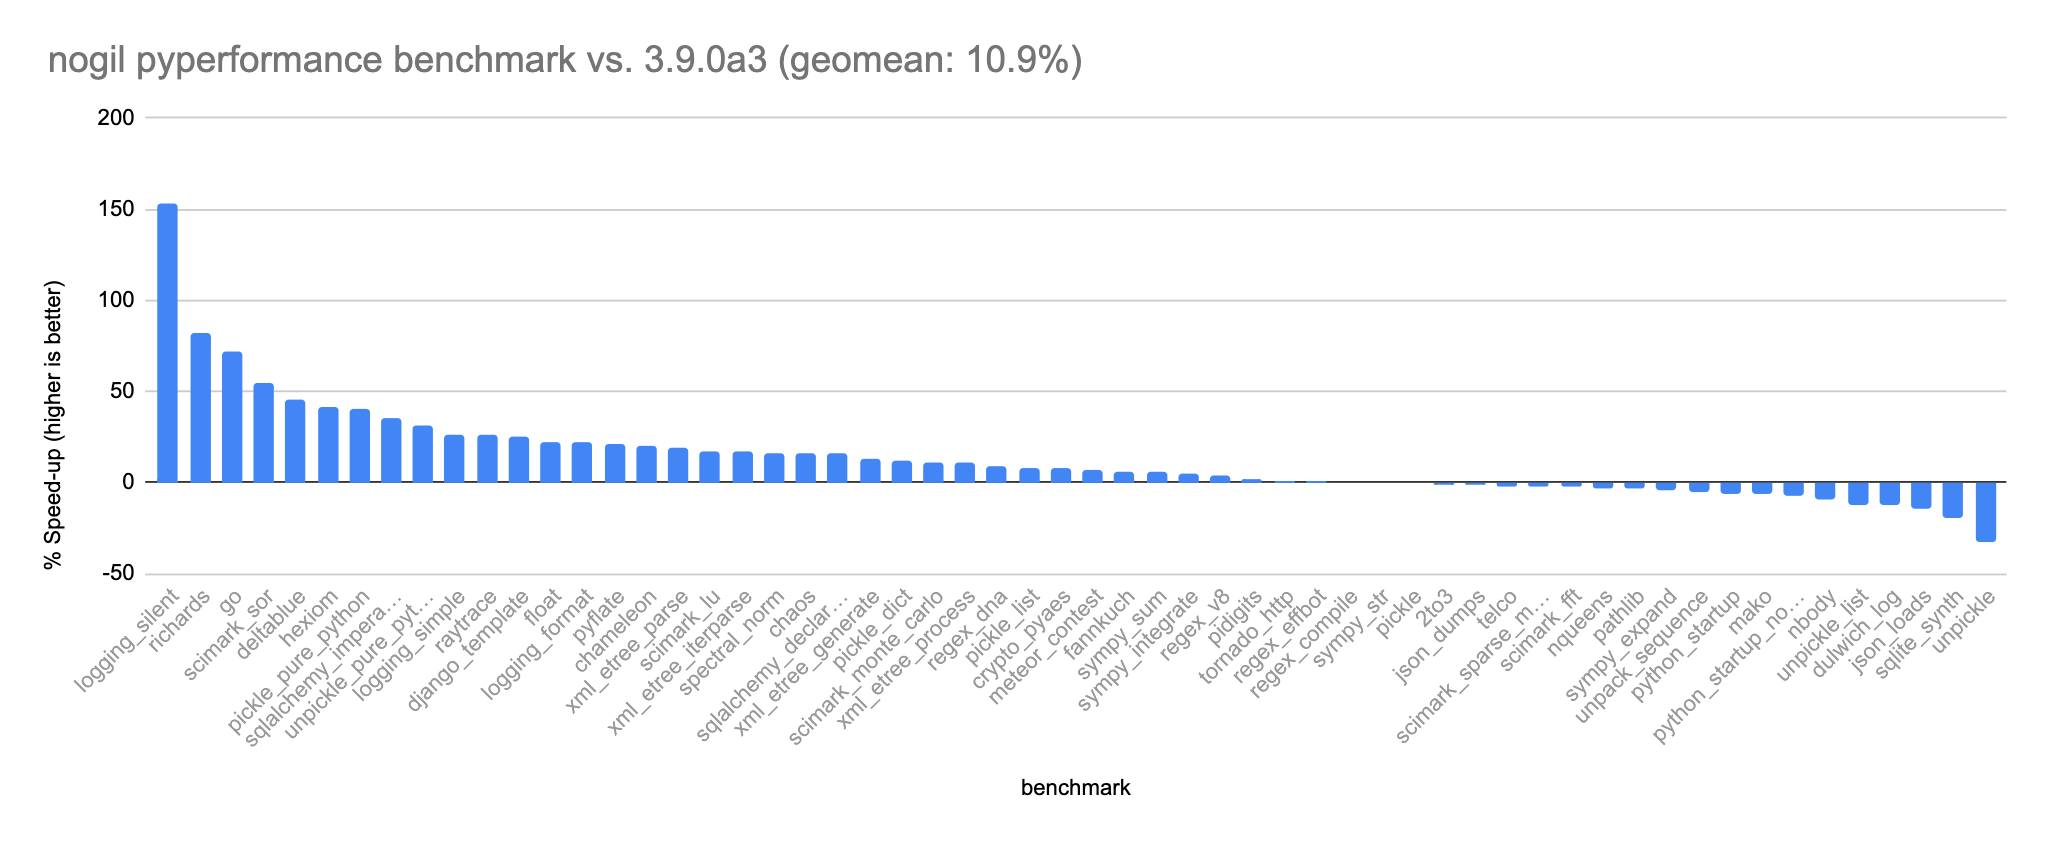

======= 2 ======


Figure 1: nogil speed-up on the pyperformance benchmark suite compared to Python 3.9.0a3. The geometric mean of the speed-up is 10.9% across 58 benchmarks. The fastest speed-up is on “logging_silent” due to faster function calls. The largest regression (-32%) is on the unpickle benchmark.Compilation used GCC 9 with PGO enabled.


In [13]:
from IPython.display import display

multi = chunk.render("multi")
for idx, item in enumerate(multi):
    print(f"======= {idx} ======")
    if isinstance(item, str):
        print(item)
        continue
    
    print(item)
    display(item['content'])

#### Find chunk

To find chunk matching some criteria, you can do `chunk.find(id, ctype)` to get the first matched chunk, or `chunk.find_all(ctype)` to get all matched chunks from that level.

In [14]:
header = chunk.find(ctype="header")
print(header)

Chunk(id=a1666, ctype=header, content=Why remove the GIL?)


In [15]:
headers = chunk.find_all(ctype="header")
for each in headers:
    print(each)

Chunk(id=a1666, ctype=header, content=Why remove the GIL?)
Chunk(id=c4a90, ctype=header, content=Design)
Chunk(id=dca3c, ctype=header, content=Reference counting)
Chunk(id=59e75, ctype=header, content=Immortalization)
Chunk(id=3ac11, ctype=header, content=Deferred reference counting)
Chunk(id=30f2a, ctype=header, content=Performance)


#### Navigate

Starting from a chunk, it's possible to navigate to the surrounding chunks.

In [16]:
print(header)

print()
print("To next chunk:")
next_chunk = header.next
print(next_chunk)

print()
print("To first child chunk:")
child = next_chunk.child
print(child)

print()
print("Back to parent:")
parent = child.parent
print(parent)

print()
print("To previous chunk:")
prev_chunk = parent.prev
print(prev_chunk)

Chunk(id=a1666, ctype=header, content=Why remove the GIL?)

To next chunk:
Chunk(id=c4a90, ctype=header, content=Design)

To first child chunk:
Chunk(id=dca3c, ctype=header, content=Reference counting)

Back to parent:
Chunk(id=c4a90, ctype=header, content=Design)

To previous chunk:
Chunk(id=a1666, ctype=header, content=Why remove the GIL?)


#### Persist chunks

`easyparser` supports storing and loading chunks for later use.

In [17]:
from easyparser.store.fs import FileStore

store = FileStore("temp")
chunk.store = store

chunk.save(relations=True)

The chunk should be stored in the `temp/` directory inside this cookbook. To load the chunk:

In [18]:
store2 = FileStore("temp")
loaded_chunk = store2.get(chunk.id)

In [19]:
print(f"{loaded_chunk=}")
print(f"{loaded_chunk.child=}")

loaded_chunk=Chunk(id=f83d8, ctype=root, origin=assets/sample.docx)
loaded_chunk.child=Chunk(id=e31e3, ctype=para, content=(abridged from Sam Gross’s doc: https://docs.googl... (1 more words))


In [20]:
# Clean up
import shutil
shutil.rmtree("temp")